In [1]:
import os
import tkinter as tk
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

In [2]:
class UNet(nn.Module):
    """ Generator model """

    def __init__(self, d=64):
        super(UNet, self).__init__()
        # Unet encoder
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d * 8)
        self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d * 8)
        self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d * 8)
        self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        # self.conv8_bn = nn.BatchNorm2d(d * 8)

        # Unet decoder
        self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 8)
        self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 8)
        self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d * 8)
        self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d * 4)
        self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(d * 2)
        self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(d)
        self.deconv8 = nn.ConvTranspose2d(d * 2, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))
        # e8 = self.conv8_bn(self.conv8(F.leaky_relu(e7, 0.2)))
        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        d1 = torch.cat([d1, e7], 1)
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e6], 1)
        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)
        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        # d4 = F.dropout(self.deconv4_bn(self.deconv4(F.relu(d3))), 0.5)
        d4 = torch.cat([d4, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        o = nn.Tanh()(d8)

        return o
    
class DrawingApp(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)
        self.title('Draw pokemon')
        self.previous_x = self.previous_y = 0
        self.x = self.y = 0
        self.points_recorded = []
        
        if os.name == 'nt':
            dim = 336
        else:
            dim = 338
        
        self.canvas = tk.Canvas(self, width=dim, height=dim, bg = "white", cursor="cross")
        self.canvas.pack(side="top", fill="both", expand=True)
        
        self.button_clear = tk.Button(self, text = "Clear", command = self.clear_all)
        self.button_clear.pack(side="top", fill="both", expand=True)
        self.button_save = tk.Button(self, text = "Save", command = self.save)
        self.button_save.pack(side="top", fill="both", expand=True)
        
        self.canvas.bind("<Motion>", self.tell_me_where_you_are)
        self.canvas.bind("<B1-Motion>", self.draw_from_where_you_are)

    def clear_all(self):
        self.canvas.delete("all")

    def save(self):
        self.canvas.postscript(file = 'tmp.eps') 
        img = Image.open('tmp.eps') 
        img.save('drawing_out.png', 'png') 
        
    def tell_me_where_you_are(self, event):
        self.previous_x = event.x
        self.previous_y = event.y

    def draw_from_where_you_are(self, event):
        if self.points_recorded:
            self.points_recorded.pop()
            self.points_recorded.pop()

        self.x = event.x
        self.y = event.y
        self.canvas.create_line(self.previous_x, self.previous_y, 
                                self.x, self.y,fill="black")
        self.points_recorded.append(self.previous_x)
        self.points_recorded.append(self.previous_y)
        self.points_recorded.append(self.x)     
        self.points_recorded.append(self.x)        
        self.previous_x = self.x
        self.previous_y = self.y

In [54]:
def apply_model_to_img():
    edge_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
    
    img_tensor = None
    
    with Image.open('./drawing_out.png') as img:
        img_tensor = edge_transforms(img).unsqueeze(0)
    
    state_dict = torch.load('../trained_models/etheral-sweep-9.pt', map_location=torch.device('cpu'))
    model = UNet()
    model.load_state_dict(state_dict['generator_state_dict'])
    model.eval()  # Try commenting out this line to see the difference!
    out_img = model(img_tensor).squeeze(0)
    out_img = out_img.permute(1, 2, 0).detach().numpy()
    plt.imshow(out_img)
    plt.show()

# Draw a pokemon
When the drawing is finished click save and then close the drawing window.

In [29]:
app = DrawingApp()
app.mainloop()

# Run the cell bellow to see the model output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


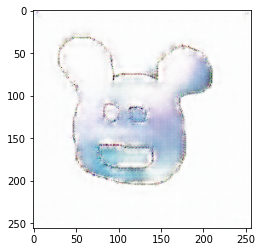

In [55]:
apply_model_to_img()